In [88]:
import numpy as np
import os
import pandas as pd
import re
import requests
import kagglehub
import sys
import matplotlib.pyplot as plt
import pickle
from dataclasses import dataclass

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Stock Price Prediction Using Machine Learning Models

by Andon Gorchov (@thunderman913)

## Abstract

This project aims to build machine learning models, which are good at predicting stock prices, based on stock and financial data. Various models will be explored, including Support Vector Regression (SVR), K-Nearest Neighbors (KNN), Random Forest Regressors (RFR) and Linear Regression The analysis uses historical stock data, which includes factors such as the value of a stock, trade volume and economic indicators. In order to train and evaluate this model, the dataset is pre-processed and analyzed under appropriate conditions, so that the model can be run. Apart from the data, hyperparameter tuning is performed using GridSearchCV to find the optimal parameters for each algorithm. The performance of the models is evaluated using Mean Squared Error (MSE) to compare their accuracy in predicting stock closing prices. The findings provide insights into the effectiveness of different machine learning techniques for stock price forecasting, highlighting the strengths and limitations of each approach in dealing with financial market data.

## 1. Problem Definition

Trying to predict the stock market price is a century old task, that no one has yet perfected. The big corporations and hedge funds put their best effort to outsmart the normal traders, but still they sometimes fail. There has not been a perfect tool for predicting the price and if one comes out at any point, it will for sure disrupt the market. The project's main goal is to create machine learning models, that are sufficient in predicting the price of a stock. Two different datasets will be used to achieve this goal - stock price data and earnings data. Everything will be preprocessed, so that the models can be run on it and hopefully predict close to the actual data. 4 different models will be explored and experimented with, so we can see, which one performs best in our circumstances. The hyperparameters will be tuned as much as possible, but since the dataset has 27 different features and nearly 7 million rows - the task to perfect the model will be difficult. In no means, I am expecting the models to predict accurately to the actual price, but I do expected, that some models work much better than others.

## 2. Data analysis and tidying

We will need some stock datasets and the perfect one for this task is this one:

https://www.kaggle.com/datasets/tsaustin/us-historical-stock-prices-with-earnings-data

It contains daily stock price informations for more than 7000 tickers. Also it has earnings data for the different stock. Some are quarterly, others are yearly, but we will figure out how to use them. First lets define some methods, that will be used for reading the data.

In order not to download the dataset locally, we can read it from the remote using those paths.

In [ ]:
path = kagglehub.dataset_download("tsaustin/us-historical-stock-prices-with-earnings-data")

earnings_path = f"{path}\\stocks_latest\\earnings_latest.csv"
stock_prices_path = f"{path}\\stocks_latest\\stock_prices_latest.csv"

In [112]:
# Calculate the peak price over a rolling window and days since the peak price
def get_peak_price_and_days_ago(df):
    df['peak_price'] = df['close'].rolling(window=90, min_periods=1).max()
    peak_day_index = df['close'].rolling(window=90, min_periods=1).apply(lambda x: (len(x) - 1 - x.argmax()), raw=False)
    df['peak_days_ago'] = peak_day_index.fillna(0).astype(int)  # Fill NaN for rows that don't have enough data
    return df

# Adds features like prices and volumes for specific days ago for each stock (ticker)
# and calculates the peak price and days since the peak price
def process_ticker_data(df):
    # Add columns for prices X days ago
    for days in [1,2,3,4,5, 10, 15, 30, 60, 90]:
        df[f'price_{days}_days_ago'] = df.groupby('ticker')['close'].shift(days)
        df[f'volume_{days}_days_ago'] = df.groupby('ticker')['volume'].shift(days)

    df = df.groupby('ticker', group_keys=False).apply(get_peak_price_and_days_ago)

    return df

In [91]:
# Adding earnings data to stock_data_tidy based on the nearest previous date
def add_earnings_data(stock_data, earnings):
    merged_df = pd.merge_asof(
        stock_data.sort_values(by='date'),
        earnings.sort_values(by='earnings_date'),
        by='ticker',
        left_on='date',
        right_on='earnings_date',
        direction='backward'
    )
    
    # Ensure non-trading days are adjusted properly
    merged_df = merged_df.sort_values(by=['ticker', 'date'])

    merged_df = pd.merge_asof(
        merged_df.sort_values(by='date'),
        earnings[['ticker', 'earnings_date']].sort_values(by='earnings_date'),
        by='ticker',
        left_on='date',
        right_on='earnings_date',
        direction='forward',
        suffixes=('', '_next'),
        allow_exact_matches=False
    )
    
    # Remove NA earnings dates
    merged_df = merged_df.drop(merged_df[(merged_df.earnings_date.isna()) | (merged_df.earnings_date_next.isna())].index)
    merged_df['days_till_report'] = (merged_df['earnings_date_next'] - merged_df['date']).dt.days
    merged_df['days_since_report'] = (merged_df['date'] - merged_df['earnings_date']).dt.days

    return merged_df

In [ ]:
# Read and tidy the earnings data dataset
def getEarningsData():
    earnings_data_file = './pickles/earnings_data_processed.pkl'

    if os.path.exists(earnings_data_file):
        return pd.read_pickle(earnings_data_file)

    earnings_data = pd.read_csv(earnings_path)

    earnings_data_tidy = earnings_data
    earnings_data_tidy.date = pd.to_datetime(earnings_data_tidy.date)

    earnings_data_tidy = earnings_data_tidy.rename(columns={'symbol': 'ticker'})

    earnings_data_tidy = earnings_data_tidy.drop(earnings_data_tidy[(earnings_data_tidy.eps.isna()) | (earnings_data_tidy.eps_est.isna())].index)
    earnings_data_tidy = earnings_data_tidy.drop(columns=['qtr'])

    earnings_data_tidy = earnings_data_tidy.rename(columns={'date': 'earnings_date'})

    earnings_data_tidy['release_time'] = earnings_data_tidy.groupby('ticker')['release_time'].ffill().bfill()

    earnings_data_tidy.to_pickle(earnings_data_file)

    return earnings_data_tidy

Pickles will be used for most of the data processed/machine learning models, because those are slow operations and it is better for us, not to perform them every time.

In [93]:
stock_data_file = './pickles/stock_data_processed.pkl'

In [113]:
# Read and tidy the stock data dataset
def getTidiedStockData():
    # Check if the file exists
    if os.path.exists(stock_data_file):
        return pd.read_pickle(stock_data_file)

    # Read the basic data and some tidying
    stock_data = pd.read_csv(stock_prices_path)
    stock_data_tidy = stock_data

    stock_data_tidy.date = pd.to_datetime(stock_data_tidy.date)
    stock_data_tidy = stock_data_tidy.rename(columns={'symbol': 'ticker'})
    stock_data_tidy = stock_data_tidy.drop(columns=['split_coefficient'])

    earnings_data_tidy = getEarningsData()

    stock_data_tidy = stock_data_tidy[(stock_data_tidy['date'] > (earnings_data_tidy['earnings_date'].min() - pd.Timedelta(days=100)))
                                    | (stock_data_tidy['date'] < earnings_data_tidy['earnings_date'].max() + pd.Timedelta(days=5))]

    stock_data_tidy = stock_data_tidy.sort_values(by=['ticker', 'date'], ascending=[True, True])

    stock_data_tidy = process_ticker_data(stock_data_tidy)

    stock_data_tidy = stock_data_tidy[stock_data_tidy.price_90_days_ago.isna() == False]
    
    stock_data_tidy = add_earnings_data(stock_data_tidy, earnings_data_tidy)

    # Encode labels
    le = LabelEncoder()
    stock_data_tidy['ticker_encoded'] = le.fit_transform(stock_data_tidy['ticker'])
    
    stock_data_tidy.to_pickle(stock_data_file)

    return stock_data_tidy

In [95]:
stock_data_tidy = getTidiedStockData()

After everything writte above, we can just call the above method and get all of the data needed for the machine learning.

In [114]:
stock_data_tidy

,ticker,date,close,price_1_days_ago,volume_1_days_ago,price_2_days_ago,volume_2_days_ago,price_3_days_ago,volume_3_days_ago,price_4_days_ago,...,peak_price,peak_days_ago,earnings_date,eps_est,eps,release_time,earnings_date_next,days_till_report,days_since_report,ticker_encoded
11137135,C,2012-07-16,26.8100,26.6500,48422100.0,25.2800,36919200.0,25.8700,37863200.0,25.8800,...,38.08,81,2012-07-16,0.88,0.95,pre,2012-10-15,91,0,718
11138878,CSX,2012-07-17,22.7900,22.5900,4914000.0,22.6600,6924700.0,22.1200,9163700.0,22.2500,...,22.79,0,2012-07-17,0.47,0.49,post,2012-10-16,91,0,1105
11138900,FIS,2012-07-17,34.2300,34.3000,1234200.0,34.3200,2182500.0,33.9300,1274200.0,34.1200,...,34.80,9,2012-07-17,0.60,0.66,post,2012-11-05,111,0,1605
11139425,WYNN,2012-07-17,97.3600,96.4400,2089100.0,96.2200,2589100.0,96.7500,2807400.0,100.6400,...,135.04,55,2012-07-17,1.48,1.38,post,2012-10-24,99,0,4548
11140712,C,2012-07-17,27.3800,26.8100,59427600.0,26.6500,48422100.0,25.2800,36919200.0,25.8700,...,38.08,82,2012-07-16,0.88,0.95,pre,2012-10-15,90,1,718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23691461,ADXS,2021-06-10,0.5244,0.5233,10176718.0,0.5096,8778783.0,0.5263,7635297.0,0.5078,...,1.41,79,2020-09-10,-0.15,-0.09,post,2021-06-14,4,273,81
23692035,RFIL,2021-06-10,7.9600,7.9300,14128.0,7.9600,87371.0,7.9800,27703.0,7.9600,...,7.98,5,2021-03-11,0.03,-0.03,pre,2021-06-14,4,91,3506
23693010,ADXS,2021-06-11,0.5156,0.5244,5190814.0,0.5233,10176718.0,0.5096,8778783.0,0.5263,...,1.41,80,2020-09-10,-0.15,-0.09,post,2021-06-14,3,274,81
23693122,RFIL,2021-06-11,7.8000,7.9600,26264.0,7.9300,14128.0,7.9600,87371.0,7.9800,...,7.98,6,2021-03-11,0.03,-0.03,pre,2021-06-14,3,92,3506


We can see the features it has - ticker, prices and volumes for each day, latest earnings, days since and till next report and also the peak price.

The earnings have been added to the actual data, but with a different frequence and this is the reason why, the columns days_till_report and days_since_report are introduces. Every single row has the latest earnings. For example if the earnings are 5 days ago, we fill those. If the earnings happened today we fill them. If they happened 70 days ago, we fill them with the latest ones. Having the days to and since the next report will help our model understand this.

In [96]:
stock_data_tidy[['ticker','date', 'earnings_date', 'earnings_date_next', 'days_till_report', 'days_since_report']]

,ticker,date,earnings_date,earnings_date_next,days_till_report,days_since_report
11137135,C,2012-07-16,2012-07-16,2012-10-15,91,0
11138878,CSX,2012-07-17,2012-07-17,2012-10-16,91,0
11138900,FIS,2012-07-17,2012-07-17,2012-11-05,111,0
11139425,WYNN,2012-07-17,2012-07-17,2012-10-24,99,0
11140712,C,2012-07-17,2012-07-16,2012-10-15,90,1
...,...,...,...,...,...,...
23691461,ADXS,2021-06-10,2020-09-10,2021-06-14,4,273
23692035,RFIL,2021-06-10,2021-03-11,2021-06-14,4,91
23693010,ADXS,2021-06-11,2020-09-10,2021-06-14,3,274
23693122,RFIL,2021-06-11,2021-03-11,2021-06-14,3,92


We remove data with more than 120 days on both next and previous report, since that is useless data for our case. We want the model to be able to predict data, when it has enough information about it.

We also remove some columns, that are not used in the trainings:

open, high, low, close_adjusted and volume - those are features, that are about our current day, that we want to predict. For the previous days for the most part, we shouldn't care, what those are, since we are gonna have the close price.

In [97]:
stock_data_tidy = stock_data_tidy.drop(stock_data_tidy[(stock_data_tidy.days_till_report > 120) & (stock_data_tidy.days_since_report > 120)].index)
# Remove useless columns
stock_data_tidy = stock_data_tidy.drop(columns=['open', 'high', 'low', 'close_adjusted', 'volume'])

In [121]:
stock_data_tidy.shape[0]

6713717

In [125]:
stock_data_tidy.ticker.unique().shape[0]

4640

We can see, that we have 6.7 million rows of data with 4640 different stocks being tracked. That should be pretty much enough data for our task.

## 3. Model Training

### 3.1. Forest Regressor

In [98]:
features = [
    'ticker_encoded', 'peak_price', 'peak_days_ago', 'price_1_days_ago', 'volume_1_days_ago',
    'price_2_days_ago', 'volume_2_days_ago', 'price_3_days_ago', 'volume_3_days_ago',
    'price_4_days_ago', 'volume_4_days_ago', 'price_5_days_ago', 'volume_5_days_ago',
    'price_10_days_ago', 'volume_10_days_ago', 'price_15_days_ago', 'volume_15_days_ago',
    'price_30_days_ago', 'volume_30_days_ago', 'price_60_days_ago', 'volume_60_days_ago',
    'price_90_days_ago', 'volume_90_days_ago', 'eps_est', 'eps', 'days_till_report', 'days_since_report'
]

target = 'close'

In [99]:
@dataclass
class PreparedData:
    X_train: any
    X_test: any
    y_train: any
    y_test: any
    X_final_test: any
    y_final_test: any
    scaler_X: any = None
    scaler_y: any = None

def prepare_data(data, features, target, scale_output, frac=0.05):
    stock_data_tidy_train = data.sample(frac=frac, random_state=42)
    
    X = stock_data_tidy_train[features]
    y = stock_data_tidy_train[target]

    scaler_X = StandardScaler()
    X = scaler_X.fit_transform(X)
    
    if scale_output:    
        scaler_y = StandardScaler()
        y = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()
    else:
        scaler_X, scaler_y = None, None
    
    X_main, X_final_test, y_main, y_final_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=0.2, random_state=42)
    
    return PreparedData(
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        X_final_test=X_final_test,
        y_final_test=y_final_test,
        scaler_X=scaler_X,
        scaler_y=scaler_y
    )

In [100]:
forest_grid_search_data = prepare_data(stock_data_tidy, features, target, False, 0.005)

In [101]:
forest_grid_search_path = './pickles/forest_grid_search.pkl'

In [102]:
def getGridSearch():
    if os.path.exists(forest_grid_search_path):
        return pd.read_pickle(forest_grid_search_path)

    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 40],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    forest_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
    forest_grid_search.fit(forest_grid_search_data.X_train, forest_grid_search_data.y_train)

    best_params = forest_grid_search.best_params_
    print(f"Best Parameters: {best_params}")

    with open(forest_grid_search_path, 'wb') as model_file:
        pickle.dump(forest_grid_search, model_file)

    return forest_grid_search

In [103]:
forest_grid_search = getGridSearch()

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


Mean Squared Error for n_estimators=1: 213.62836482477752
Mean Squared Error for n_estimators=20: 20.845772824635056
Mean Squared Error for n_estimators=50: 25.88730843224147
Mean Squared Error for n_estimators=75: 22.046313879624797
Mean Squared Error for n_estimators=100: 18.33769813044673
Mean Squared Error for n_estimators=150: 16.960019354668475
Mean Squared Error for n_estimators=200: 21.841726019754258


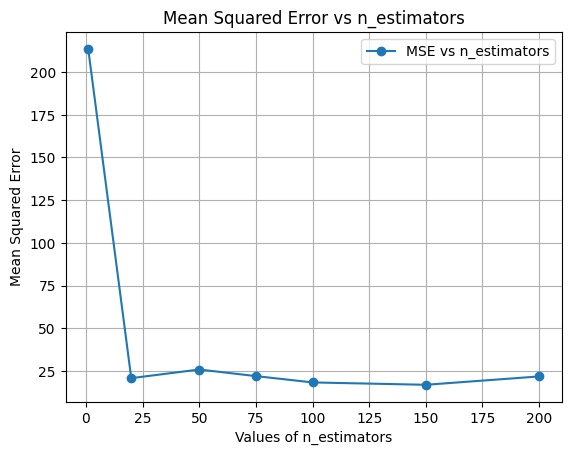

Mean Squared Error for max_depth=1: 9953.354213901817
Mean Squared Error for max_depth=5: 38.589750201133334
Mean Squared Error for max_depth=10: 24.302329658182952
Mean Squared Error for max_depth=20: 22.314674185281955
Mean Squared Error for max_depth=40: 21.841726019754258


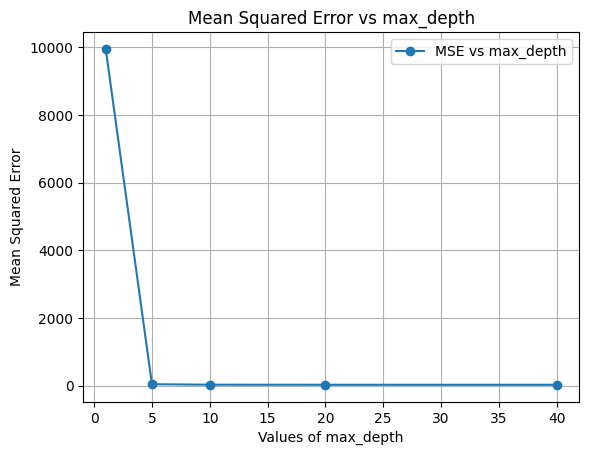

Mean Squared Error for min_samples_split=2: 21.841726019754258
Mean Squared Error for min_samples_split=5: 50.46972566962456
Mean Squared Error for min_samples_split=10: 151.4560884075119
Mean Squared Error for min_samples_split=15: 229.22145342167644
Mean Squared Error for min_samples_split=20: 333.74750186900707


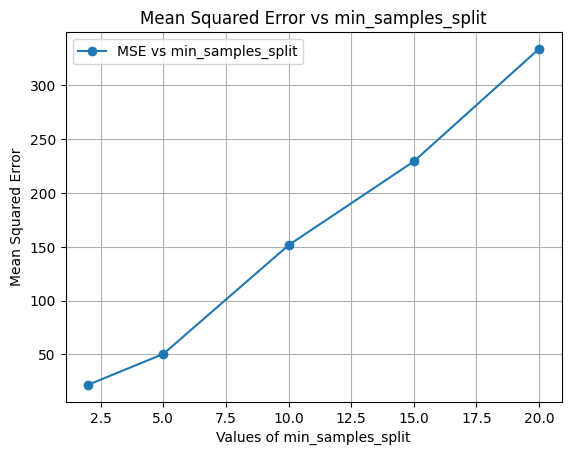

Mean Squared Error for min_samples_leaf=1: 333.74750186900707
Mean Squared Error for min_samples_leaf=2: 9681.50417511592
Mean Squared Error for min_samples_leaf=4: 2837916.9513470856
Mean Squared Error for min_samples_leaf=8: 3149072.2525724545
Mean Squared Error for min_samples_leaf=12: 2346982.9355607503
Mean Squared Error for min_samples_leaf=20: 1303418.313446646


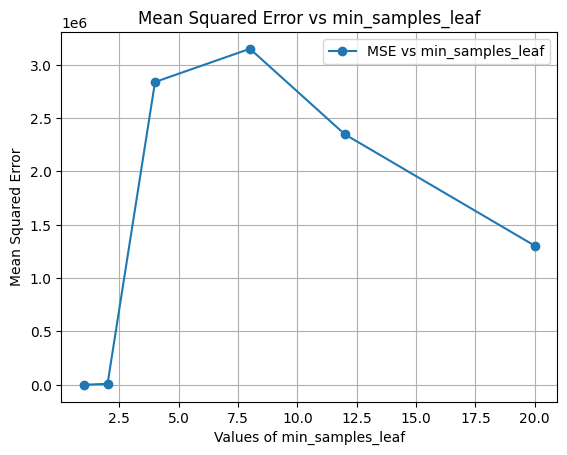

In [104]:
def evaluate_param(param_name, param_values):
    mse_values = []
    for value in param_values:
        model_params = forest_grid_search.best_params_
        model_params[param_name] = value
        model = RandomForestRegressor(**model_params, random_state=42)
        model.fit(forest_grid_search_data.X_train, forest_grid_search_data.y_train)
        y_pred = model.predict(forest_grid_search_data.X_test)
        mse = mean_squared_error(forest_grid_search_data.y_test, y_pred)
        mse_values.append(mse)
        print(f"Mean Squared Error for {param_name}={value}: {mse}")
    
    # Plot MSE for the parameter
    plt.figure()
    plt.plot(param_values, mse_values, marker='o', linestyle='-', label=f'MSE vs {param_name}')
    plt.xlabel(f'Values of {param_name}')
    plt.ylabel('Mean Squared Error')
    plt.title(f'Mean Squared Error vs {param_name}')
    plt.grid(True)
    plt.legend()
    plt.show()

n_estimators_values = [1, 20, 50, 75, 100, 150, 200]
evaluate_param('n_estimators', n_estimators_values)

max_depth_values = [1, 5, 10, 20, 40]
evaluate_param('max_depth', max_depth_values)

min_samples_split_values = [2, 5, 10, 15, 20]
evaluate_param('min_samples_split', min_samples_split_values)

min_samples_leaf_values = [1, 2, 4, 8, 12, 20]
evaluate_param('min_samples_leaf', min_samples_leaf_values)

The best params seem to be {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}. Let's train the model with them

In [ ]:
forest_model_data = prepare_data(stock_data_tidy, features, target, False, 1)

C:\Users\andon\AppData\Roaming\Python\Python312\site-packages\numpy\_core\_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\andon\AppData\Roaming\Python\Python312\site-packages\numpy\_core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\andon\AppData\Roaming\Python\Python312\site-packages\numpy\_core\_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
forest_model = RandomForestRegressor(n_estimators=20, max_depth=20,min_samples_split=2, min_samples_leaf=1, random_state=42)

# Fit the model to your training data
forest_model.fit(forest_model_data.X_train, forest_model_data.y_train)

C:\Users\andon\AppData\Roaming\Python\Python312\site-packages\numpy\_core\_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\andon\AppData\Roaming\Python\Python312\site-packages\numpy\_core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\andon\AppData\Roaming\Python\Python312\site-packages\numpy\_core\_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


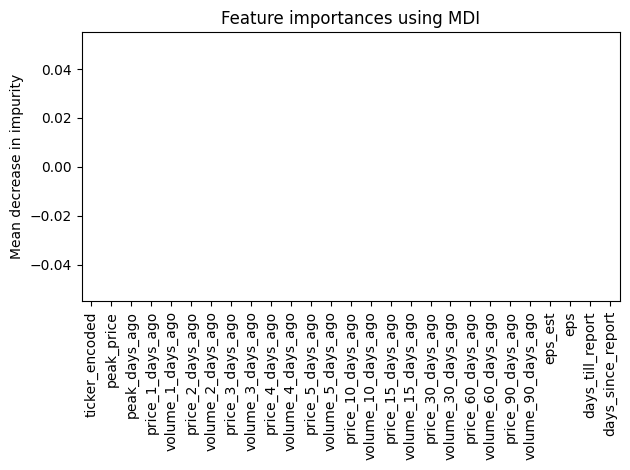

In [ ]:
# TODO investigate the importances on the actual result
std = np.std([tree.feature_importances_ for tree in forest_model.estimators_], axis=0)

importances = forest_model.feature_importances_
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=features)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## 3.2. Linear Regression

Linear Regression TODO check if all good and improve :)

In [111]:
linear_regression_data = prepare_data(stock_data_tidy, features, target, False, 1)

Training Score: 0.9999291653900366
Mean Squared Error: 558.050724454366


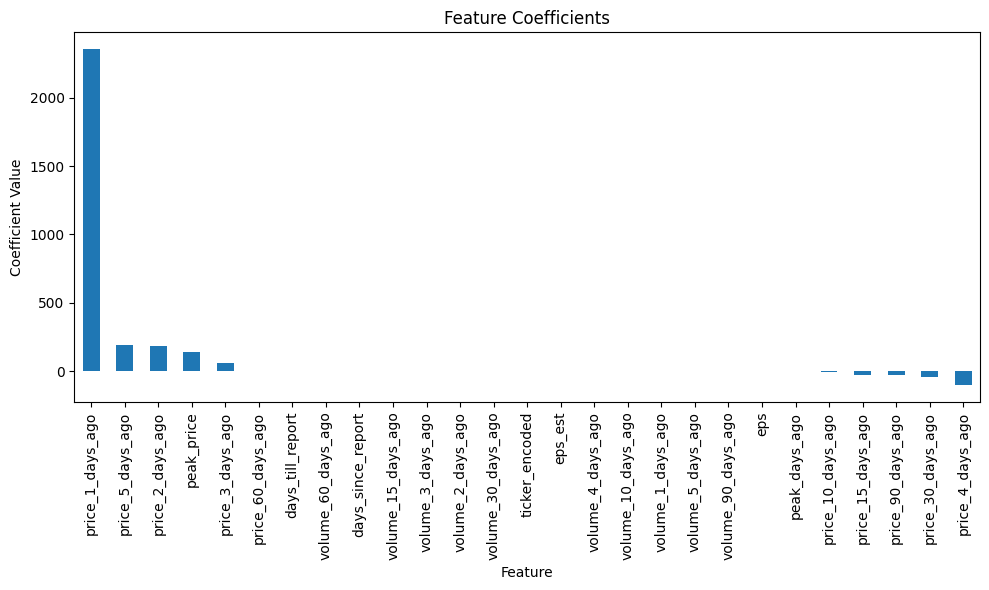

In [ ]:
linear_model = LinearRegression()
linear_model.fit(linear_regression_data.X_train, linear_regression_data.y_train)

# Score the model on the training data
train_score = linear_model.score(linear_regression_data.X_train, linear_regression_data.y_train)
print(f"Training Score: {train_score}")

# Make predictions on the test set
y_pred = linear_model.predict(linear_regression_data.X_test)

# Calculate and print the mean squared error
mse = np.mean((linear_regression_data.y_test - y_pred) ** 2)
print(f"Mean Squared Error: {mse}")

# Linear regression does not provide feature importances in the same way as RandomForest
# Instead, we can look at the coefficients
coefficients = pd.Series(linear_model.coef_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
coefficients.plot(kind='bar')
plt.title('Feature Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
train_score = linear_model.score(linear_regression_data.X_final_test, linear_regression_data.y_final_test)
print(f"Training Score: {train_score}")

Training Score: 0.9999200251178422


In [ ]:
# Test a certain row
linear_regression_data.X_final_test[1].__len__()
predicted_close = linear_model.predict(linear_regression_data.X_final_test[-4].reshape(1,-1))
predicted_close

predicted_close / linear_regression_data.y_final_test[20869336]


KeyError: 20869336

### 3.3. Support Vector Regression

In [ ]:
svr_grid_search_data = prepare_data(stock_data_tidy, features, target, True, 0.001)

In [ ]:
svr_grid_search_path = './pickles/svr_grid_search.pkl'

In [ ]:
def getSvrGridSearch():
    if os.path.exists(svr_grid_search_path):
        return pd.read_pickle(svr_grid_search_path)

    param_grid = {
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.01, 0.1, 0.5, 1],
        'kernel': ['linear', 'rbf', 'poly']
    }

    svr = SVR()
    svr_grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    svr_grid_search.fit(svr_grid_search_data.X_train, svr_grid_search_data.y_train)

    with open(svr_grid_search_path, 'wb') as model_file:
        pickle.dump(svr_grid_search, model_file)

    # Best parameters from GridSearchCV
    best_params_svr = svr_grid_search.best_params_
    print(f"Best Parameters for SVR: {best_params_svr}")

    return svr_grid_search

In [ ]:
svr_grid_search = getSvrGridSearch()

In [ ]:
# Train the best SVR model
best_svr_model = svr_grid_search.best_estimator_
y_pred_svr_scaled = best_svr_model.predict(svr_grid_search_data.X_test)

# Inverse transform the predictions to convert back to actual prices
y_pred_svr = svr_grid_search_data.scaler_y.inverse_transform(y_pred_svr_scaled.reshape(-1, 1)).ravel()

# Calculate and print the mean squared error for SVR
y_test_original = svr_grid_search_data.scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
mse_svr = mean_squared_error(y_test_original, y_pred_svr)
print(f"Mean Squared Error for SVR: {mse_svr}")

NameError: name 'X_test' is not defined

In [ ]:
best_svr_model.score(svr_grid_search_data.X_final_test, svr_grid_search_data.y_final_test)

NameError: name 'X_final_test' is not defined

### 3.4. K-Nearest Neighbors

In [ ]:
knn_grid_search_data = prepare_data(stock_data_tidy, features, target, True, 0.05)

In [ ]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1 for Manhattan distance, p=2 for Euclidean distance
}

knn = KNeighborsRegressor()
knn_grid_search = GridSearchCV(knn, param_grid_knn, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
knn_grid_search.fit(knn_grid_search_data.X_train, knn_grid_search_data.y_train)

# Best parameters from GridSearchCV for KNN
best_params_knn = knn_grid_search.best_params_
print(f"Best Parameters for KNN: {best_params_knn}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters for KNN: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


In [ ]:
# Train the best KNN model
best_knn_model = knn_grid_search.best_estimator_
y_pred_knn_scaled = best_knn_model.predict(knn_grid_search_data.X_test)

# Inverse transform the predictions to convert back to actual prices
y_pred_knn = knn_grid_search_data.scaler_y.inverse_transform(y_pred_knn_scaled.reshape(-1, 1)).ravel()

# Calculate and print the mean squared error for KNN
y_test_original = knn_grid_search_data.scaler_y.inverse_transform(knn_grid_search_data.y_test.reshape(-1, 1)).ravel()
mse_knn = mean_squared_error(y_test_original, y_pred_knn)
print(f"Mean Squared Error for KNN: {mse_knn}")

Mean Squared Error for KNN: 994.8890553354986


In [ ]:
knn_grid_search_path = './pickles/knn_grid_search.pkl'

In [ ]:
with open(knn_grid_search_path, 'wb') as model_file:
    pickle.dump(knn_grid_search, model_file)

In [ ]:
if os.path.exists(knn_grid_search_path):
    tst = pd.read_pickle(knn_grid_search_path)

In [ ]:
tst.best_params_

{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

## 4. Conclusion